<a href="https://colab.research.google.com/github/rahiakela/data-science-research-and-practice/blob/main/data-science-bookcamp/case-study-3--disease-outbreaks/03_case_study_disease_outbreaks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Case Study: disease outbreaks

Our goal is to extract locations from disease-related headlines to uncover the largest active epidemics within and outside of the United States. 

We will do as follows:

1. Load the data.
2. Extract locations from the text using regular expressions and the GeoNames-
Cache library.
3. Check the location matches for errors.
4. Cluster the locations based on geographic distance.
5. Visualize the clusters on a map, and remove any errors.
6. Output representative locations from the largest clusters to draw interesting conclusions.

##Setup

Reference:
https://colab.research.google.com/github/astg606/py_materials/blob/master/visualization/introduction_cartopy.ipynb

In [ ]:
!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install cython
!pip install cartopy

In [ ]:
!apt-get -qq install python-cartopy python3-cartopy
!pip uninstall -y shapely    # cartopy and shapely aren't friends (early 2020)
!pip install shapely --no-binary shapely
!pip install geonamescache
!pip install Unidecode

In [ ]:
!wget https://github.com/rahiakela/data-science-research-and-practice/raw/main/data-science-bookcamp/case-study-3--disease-outbreaks/headlines.txt

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from collections import defaultdict
import itertools
import re
import numpy as np
import pandas as pd
from scipy import stats
from math import cos, sin, asin
from math import pi

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from scipy.spatial.distance import euclidean
from sklearn.datasets import make_circles

from geonamescache import GeonamesCache

from unidecode import unidecode

import cartopy
import seaborn as sns
import matplotlib.pyplot as plt
from cartopy.crs import PlateCarree
from cartopy.crs import LambertConformal

##Extracting locations from headline data

In [6]:
# Loading headline data
with open("headlines.txt", "r") as f:
  headlines = [line.strip() for line in f.readlines()]
  num_headlines = len(headlines)
  print(f"{num_headlines} headlines have been loaded")

650 headlines have been loaded


Now we need a mechanism for extracting city and
country names from the headline text.

In [7]:
# Converting names to regexes
def name_to_regex(name):
  decoded_name = unidecode(name)
  if name != decoded_name:
    regex = fr"\b({name}|{decoded_name})\b"
  else:
    regex = fr"\b{name}\b"
  return re.compile(regex, flags=re.IGNORECASE)

Let’s create two dictionaries, `country_to_name` and `city_to_name`, which map regular expressions to country names and city
names, respectively.

In [8]:
# Mapping names to regexes
gc = GeonamesCache()

countries = [country["name"] for country in gc.get_countries().values()]
country_to_name = {name_to_regex(name): name for name in countries}

cities = [city["name"] for city in gc.get_cities().values()]
city_to_name = {name_to_regex(name): name for name in cities}

Next, we use our mappings to define a function that looks for location names in text.

In [9]:
# Finding locations in text
def get_name_in_text(text, dictionary):
  for regex, name in sorted(dictionary.items(), key= lambda x: x[1]):
    if regex.search(text):
      return name
  return None

In [10]:
# Finding locations in headlines
matched_countries = [get_name_in_text(headline, country_to_name) for headline in headlines]
matched_cities = [get_name_in_text(headline, city_to_name) for headline in headlines]
data = {"Headline": headlines, "City": matched_cities, "Country": matched_countries}

df = pd.DataFrame(data)
df.head()

,Headline,City,Country
0,Zika Outbreak Hits Miami,Miami,None
1,Could Zika Reach New York City?,New York City,None
2,First Case of Zika in Miami Beach,Miami,None
3,"Mystery Virus Spreads in Recife, Brazil",Recife,Brazil
4,Dallas man comes down with case of Zika,Dallas,None


Let’s explore our location table by summarizing the contents.

In [11]:
# Summarizing the location data
df[["City", "Country"]].describe()

,City,Country
count,618,15
unique,511,10
top,Of,Brazil
freq,44,3


The most frequently mentioned city is apparently “Of,” Turkey. That doesn’t seem right!

In [12]:
# Fetching cities named "Of"
of_cities = df[df.City == "Of"][["City", "Headline"]]
ten_of_cities = of_cities.head(10)
print(ten_of_cities.to_string(index=False))

City                                                                Headline
  Of                                   Case of Measles Reported in Vancouver
  Of Authorities are Worried about the Spread of Bronchitis in Silver Spring
  Of     Authorities are Worried about the Spread of Mad Cow Disease in Rome
  Of                    Rochester authorities confirmed the spread of Dengue
  Of                          Tokyo Encounters Severe Symptoms of Meningitis
  Of       Authorities are Worried about the Spread of Influenza in Savannah
  Of                                 Spike of Pneumonia Cases in Springfield
  Of                     The Spread of Measles in Spokane has been Confirmed
  Of                                         Outbreak of Zika in Panama City
  Of                         Urbana Encounters Severe Symptoms of Meningitis


In [13]:
# Finding multicity headlines
def get_cities_in_headline(headline):
  cities_in_headline = set()
  for regex, name in city_to_name.items():
    match = regex.search(headline)
    if match:
      if headline[match.start()].isupper():
        cities_in_headline.add(name)
  return list(cities_in_headline)

In [14]:
df["Cities"] = df["Headline"].apply(get_cities_in_headline)
df["Num_Cities"] = df["Cities"].apply(len)
# Filters out rows that do not contain multiple city matches
df_multiple_cities = df[df.Num_Cities > 1]
num_rows, _ = df_multiple_cities.shape
print(f"{num_rows} headlines match multiple cities")

71 headlines match multiple cities


In [15]:
# Sampling multicity headlines
ten_cities = df_multiple_cities[["Cities", "Headline"]].head(10)
print(ten_cities.to_string(index=False))

                       Cities                                                   Headline
        [New York City, York]                            Could Zika Reach New York City?
         [Miami, Miami Beach]                          First Case of Zika in Miami Beach
              [San Juan, San] San Juan reports 1st U.S. Zika-related death amid outbreak
   [Los Ángeles, Los Angeles]                       New Los Angeles Hairstyle goes Viral
                 [Bay, Tampa]                      Tampa Bay Area Zika Case Count Climbs
       [Ho, Ho Chi Minh City]             Zika cases in Vietnam's Ho Chi Minh City surge
             [San Diego, San]                   Key Zika Findings in San Diego Institute
          [Kuala Lumpur, Hīt]                         Kuala Lumpur is Hit By Zika Threat
         [San Francisco, San]                           Zika Virus Reaches San Francisco
[Salvador, San Salvador, San]                               Zika worries in San Salvador


In [16]:
# Selecting the longest city names
def get_longest_city(cities):
  if cities:
    return max(cities, key=len)
  return None

df["City"] = df["Cities"].apply(get_longest_city)

In [17]:
# Printing the shortest city names
short_cities = df[df.City.str.len() <= 4][["City", "Headline"]]
print(short_cities.to_string(index=False))

City                                                            Headline
Lima                                 Lima tries to address Zika Concerns
Pune                                      Pune woman diagnosed with Zika
Rome Authorities are Worried about the Spread of Mad Cow Disease in Rome
Molo                                 Molo Cholera Spread Causing Concern
Miri                                                Zika arrives in Miri
Nadi                More people in Nadi are infected with HIV every year
Baud       Rumors about Tuberculosis Spreading in Baud have been Refuted
Kobe                                      Chikungunya re-emerges in Kobe
Waco                                 More Zika patients reported in Waco
Erie                                         Erie County sets Zika traps
Kent                                        Kent is infested with Rabies
Reno                  The Spread of Gonorrhea in Reno has been Confirmed
Sibu                                       Zika sym

The results appear to be legitimate. Let’s now shift our attention from cities to countries.

In [18]:
# Fetching headlines with countries
df_countries = df[df.Country.notnull()][["City", "Country", "Headline"]]
print(df_countries.to_string(index=False))

            City   Country                                                              Headline
          Recife    Brazil                               Mystery Virus Spreads in Recife, Brazil
Ho Chi Minh City   Vietnam                        Zika cases in Vietnam's Ho Chi Minh City surge
         Bangkok  Thailand                                        Thailand-Zika Virus in Bangkok
      Piracicaba    Brazil                                   Zika outbreak in Piracicaba, Brazil
           Klang  Malaysia                                      Zika surfaces in Klang, Malaysia
  Guatemala City Guatemala Rumors about Meningitis spreading in Guatemala City have been refuted
     Belize City    Belize                                    Belize City under threat from Zika
        Campinas    Brazil                                      Student sick in Campinas, Brazil
     Mexico City    Mexico                                  Zika outbreak spreads to Mexico City
   Kota Kinabalu  Malaysia    

All of the country-bearing headlines also contain city information. 

Thus, we can assign
a latitude and longitude without relying on the country’s central coordinates.

In [19]:
# Dropping countries from the table
df.drop("Country", axis=1, inplace=True)

In [20]:
# Exploring unmatched headlines
df_unmatched = df[df.City.notnull()]
num_unmatched = len(df_unmatched)
print(f"{num_unmatched} headlines contain no city matches.")
print(df_unmatched.head(10)[["Headline"]].values)

611 headlines contain no city matches.
[['Zika Outbreak Hits Miami']
 ['Could Zika Reach New York City?']
 ['First Case of Zika in Miami Beach']
 ['Mystery Virus Spreads in Recife, Brazil']
 ['Dallas man comes down with case of Zika']
 ['Trinidad confirms first Zika case']
 ['Zika Concerns are Spreading in Houston']
 ['Geneve Scientists Battle to Find Cure']
 ['The CDC in Atlanta is Growing Worried']
 ['Zika Infested Monkeys in Sao Paulo']]


In [21]:
# Dropping unmatched headlines
df = df[~df.City.isnull()][["City", "Headline"]]
df.head()

,City,Headline
0,Miami,Zika Outbreak Hits Miami
1,New York City,Could Zika Reach New York City?
2,Miami Beach,First Case of Zika in Miami Beach
3,Recife,"Mystery Virus Spreads in Recife, Brazil"
4,Dallas,Dallas man comes down with case of Zika


## Visualizing and clustering the extracted location data

Now we can assign a latitude and longitude
to each row.

In [22]:
# Assigning geographic coordinates to cities
latitudes, longitudes = [], []
for city_name in df.City.values:
  # Chooses the matched city with the largest population
  city = max(gc.get_cities_by_name(city_name), key=lambda x: list(x.values())[0]['population'])
  # Extracts city latitudes and longitudes
  city = list(city.values())[0]
  latitudes.append(city["latitude"])
  longitudes.append(city["longitude"])

# Adds Latitude and Longitude columns to our table
df = df.assign(Latitude=latitudes, Longitude=longitudes)
df.head()

,City,Headline,Latitude,Longitude
0,Miami,Zika Outbreak Hits Miami,25.77427,-80.19366
1,New York City,Could Zika Reach New York City?,40.71427,-74.00597
2,Miami Beach,First Case of Zika in Miami Beach,25.79065,-80.13005
3,Recife,"Mystery Virus Spreads in Recife, Brazil",-8.05389,-34.88111
4,Dallas,Dallas man comes down with case of Zika,32.78306,-96.80667


Let’s execute
K-means across our set of 2D coordinates. 

We use the elbow method to choose a
reasonable value for K.

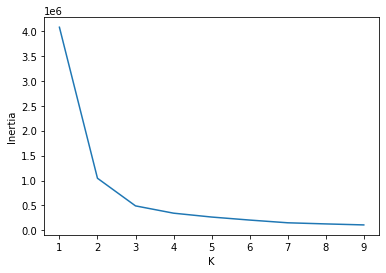

In [24]:
# Plotting a geographic elbow curve
coordinates = df[["Latitude", "Longitude"]].values
k_values = range(1, 10)
inertia_values = []

for k in k_values:
  inertia_values.append(KMeans(k).fit(coordinates).inertia_)
plt.plot(range(1, 10), inertia_values)
plt.xlabel('K')
plt.ylabel('Inertia')
plt.show()

The “elbow” in our elbow plot points to a K of 3. That K value is very low, limiting our
scope to at most three different geographic territories. 

Still, we should maintain some
faith in our analytic methodology. We cluster the locations into three groups and plot
them on a map.

In [25]:
# Using K-means to cluster cities into three groups
def plot_clusters(clusters, longitudes, latitudes):
  plt.figure(figsize=(12, 10))
  ax = plt.axes(projection=PlateCarree())
  ax.coastlines()
  ax.scatter(longitudes, latitudes, c=clusters)
  ax.set_global()
  plt.show()

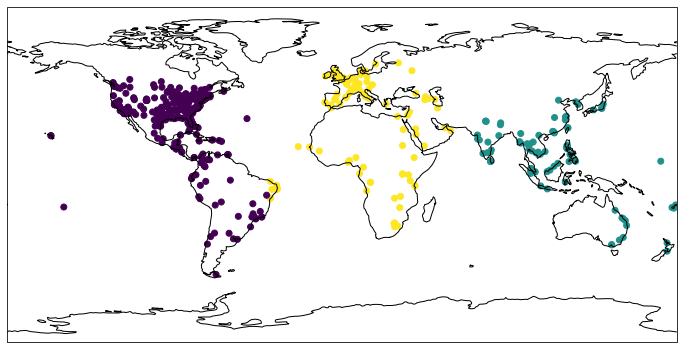

In [27]:
df["Cluster"] = KMeans(3).fit_predict(coordinates)
plot_clusters(df.Cluster, df.Longitude, df.Latitude)

The results look pretty ridiculous. Our three clusters cover

* North and South America
* Africa and Europe
* Asia and Australia

These continental categories are too broad to be useful.

These clusters are
not helpful for understanding the data. Perhaps our K was too low after all. Let’s disregard
our elbow analysis and double the size of K to 6.

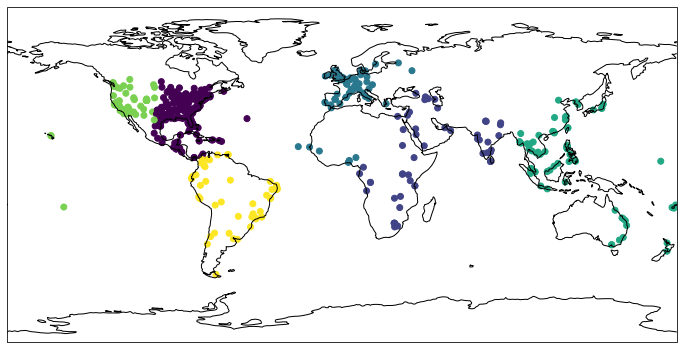

In [28]:
# Using K-means to cluster cities into six groups
df["Cluster"] = KMeans(6).fit_predict(coordinates)
plot_clusters(df.Cluster, df.Longitude, df.Latitude)

K-mean’s sense of centrality is unable to properly distinguish
between Africa, Europe, and Asia. Perhaps the algorithm’s reliance on Euclidean distance
prevents it from capturing relationships between points distributed on our
planet’s curved surface.

As an alternate approach, we can attempt to execute DBSCAN clustering.

In [29]:
# Defining a NumPy-based great-circle metric
def great_circle_distance(coord1, coord2, radius=3956):
  if np.array_equal(coord1, coord2):
    return 0.0
  coord1, coord2 = np.radians(coord1), np.radians(coord2)
  delta_x, delta_y = coord2 - coord1
  haversin = sin(delta_x / 2) ** 2 + np.product([cos(coord1[0]), cos(coord2[0]), sin(delta_y / 2) ** 2])
  return 2 * radius * asin(haversin ** .5)

In [30]:
# Using DBSCAN to cluster cities
dbscan = DBSCAN(eps=250, min_samples=3, metric=great_circle_distance)
df["Cluster"] = dbscan.fit_predict(coordinates)

DBSCAN assigns –1 to outlier data points that do not cluster. 

Let’s remove these outliers
from our table and then plot the remaining results

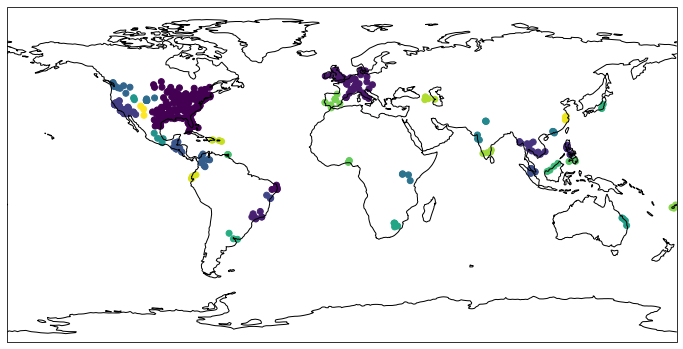

In [31]:
# Plotting non-outlier DBSCAN clusters
df_no_outliers = df[df.Cluster > -1]
plot_clusters(df_no_outliers.Cluster, df_no_outliers.Longitude, df_no_outliers.Latitude)

DBSCAN has done a decent job generating discrete clusters in parts of South America,
Asia, and southern Africa.

In [32]:
# Assigning country codes to cities
def get_country_code(city_name):
  city = max(gc.get_cities_by_name(city_name), key=lambda x: list(x.values())[0]['population'])
  return list(city.values())[0]["countrycode"]

In [33]:
df["Country_code"] = df.City.apply(get_country_code)

In [34]:
# Separating US and global cities
df_us = df[df.Country_code == "US"]
df_not_us = df[df.Country_code != "US"]

In [35]:
# Reclustering extracted cities
def re_cluster(input_df, eps):
  input_coord = input_df[["Latitude", "Longitude"]].values
  dbscan = DBSCAN(eps=eps, min_samples=3, metric=great_circle_distance)
  clusters = dbscan.fit_predict(input_coord)
  input_df = input_df.assign(Cluster=clusters)
  return input_df[input_df.Cluster > -1]

In [36]:
df_not_us = re_cluster(df_not_us, 250)
df_us = re_cluster(df_us, 125)

##Extracting insights from location clusters